# Desafio do Crédito

## Visão geral do Desafio
Como empresa de crédito, é importante saber de antemão quem é capaz de pagar seus empréstimos e quem não é. O objetivo deste desafio é analisar dados e criar um modelo para descobrir quais clientes são capazes de honrar suas dívidas.

## Estrutura
Os dados para o desafio estão no arquivo desafio_de_crédito.csv.
A inadimplência é identificada pela variável default no conjunto de dados de treinamento. As demais variáveis devem ser interpretadas, essa parte também faz parte da avaliação.
Seu objetivo é analisar os dados, prever a probabilidade de inadimplência e propor uma política de concessão de crédito com base nos dados. Uma política de concessão é a definição de quais clientes serão aprovados, e quais serão reprovados, na análise de crédito, com base em um critério racional.

## Entregável
1) Apresentação com explicação do eu você fez, incluindo metodologia, abordagem e conclusões.
2) Análise exploratória de dados, com principais descobertas, observações e padrões identificados nos dados.
3) Modelo preditivo e sugestão de política de crédito, incluindo descrição de funcionamento, justificativa de uso de cada técnica, performance esperada e resultados obtidos.
4) Códigos utilizados na análise, com instruções de uso, por exemplo, linguagem de programação, comandos para executar, dependências necessárias...
5) Arquivo chamado predictions.csv com as previsões realizadas, e sugestão de aprovação ou reprovação do crédito.

## O que avaliaremos
Sua capacidade de:
1) manipular / limpar dados
2) identificar padrões e analisar dados
3) escrever código de boa qualidade (por exemplo, reproduzível, legível)
4) aplicar modelos de aprendizado de máquina a problemas reais
5) realizar uma análise de crédito
6) dividir problemas complexos e reais em partes solucionáveis
7) explicar uma análise complexa através de uma história simples

#### Bibliotecas

In [1]:
import pandas as pd # dataframe manipulation
import numpy as np #matrix manipulation
import matplotlib.pyplot as plt # graph plot
import seaborn as sns # beautiful graphs
import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

#### Leitura do DataFrame

In [2]:
df = pd.read_csv("desafio_de_credito.csv", sep=",")

#### Info do DataFrame

In [3]:
df.info() #conhecer dataframe: columns, non-null count, dtype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64592 entries, 0 to 64591
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 64592 non-null  object 
 1   default            59966 non-null  object 
 2   risk               63807 non-null  float64
 3   var_a              63807 non-null  float64
 4   var_b              64592 non-null  float64
 5   var_c              64592 non-null  float64
 6   var_d              63807 non-null  object 
 7   var_e              63807 non-null  object 
 8   var_f              64592 non-null  object 
 9   borrowed           63807 non-null  object 
 10  months             63807 non-null  float64
 11  limit              44840 non-null  float64
 12  reason             63800 non-null  object 
 13  income             63807 non-null  object 
 14  sign               43826 non-null  object 
 15  sex                57405 non-null  object 
 16  social_network     581

#### Função p/ verificar quantidade de NaNs

In [4]:
def total_perc(df, colunas):
    total = df.isnull().sum().sort_values(ascending = False)
    perc = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    result = pd.concat([total, perc], axis=1, keys=['Total', 'Per[%]']).transpose().T
    return result

total_perc(df, df.columns)

,Total,Per[%]
Unnamed: 27,64591.0,99.998452
ok_since,38038.0,58.889646
sign,20766.0,32.149492
limit,19752.0,30.579638
n_issues,16450.0,25.467550
sex,7187.0,11.126765
social_network,6407.0,9.919185
job_name,4795.0,7.423520
default,4626.0,7.161878
n_bankruptcies,987.0,1.528053


#### Drop de linhas assumidas como desnecessárias por hipótese
* alto volume de nans
* id sem registro de default

In [5]:
df.drop(columns=['Unnamed: 27', 'ok_since', 'sign', 'limit', 'n_issues', 'social_network', 'job_name', 'reason'], inplace=True)
df.dropna(subset=['default'], inplace=True)

#### Pré-Processamento dos Dados
* Avaliar o que é object, float etc.

In [6]:
float64_list = []
object_list = []
others_list = []

for coluna in df.columns:
    if (df[coluna].dtype == "object"):
        object_list.append(coluna)
    
    elif (df[coluna].dtype == "float64"):
        float64_list.append(coluna)
    
    else:
        others_list.append(coluna)
    
    object_list_len = len(object_list)
    float64_list_len = len(float64_list)
    others_list_len = len(others_list)

print("Quantidade de object's: {}.".format(object_list_len))
print("Quantidade de float64's: {}.".format(float64_list_len))
print("Quantidade de outros: {}.".format(others_list_len))

Quantidade de object's: 12.
Quantidade de float64's: 8.
Quantidade de outros: 0.


#### Dados Tratados
* Transformar para dados numéricos;
* Tratar os NaNs em float por média;
* Tratar os NaNs em object por moda;
* Transformar object para categórico.

In [7]:
df_tratado = df.copy()

df_tratado['sex'] = df_tratado['sex'].replace(['m', 'f', 'virg', np.nan], ['male', 'female', 'others', 'others'])

cat_list = ['id', 'default', 'var_d', 'var_e', 'state', 'zipcode', 
            'sex', 'channel', 'real_state']
float_list = ['risk', 'var_f', 'borrowed', 'income', 'var_a', 'months', 
              'n_bankruptcies', 'n_defaulted_loans', 'n_accounts']

# ['Unnamed: 27', 'ok_since', 'sign', 'limit', 'n_issues', 'social_network', 'job_name']
    
for coluna in float_list:
    df_tratado[coluna] = pd.to_numeric(df_tratado[coluna], errors='coerce', downcast='float')
    df_tratado[coluna].fillna(df_tratado[coluna].mean(), inplace=True)
    
for coluna in cat_list:
    df_tratado[coluna] = df_tratado[coluna].fillna(df_tratado[coluna].mode())
    df_tratado[coluna] = df_tratado[coluna].astype('category')

#### Verificar os dtypes dos atributos

In [8]:
df_tratado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59966 entries, 0 to 64591
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 59966 non-null  category
 1   default            59966 non-null  category
 2   risk               59966 non-null  float32 
 3   var_a              59966 non-null  float32 
 4   var_b              59966 non-null  float64 
 5   var_c              59966 non-null  float64 
 6   var_d              59966 non-null  category
 7   var_e              59966 non-null  category
 8   var_f              59966 non-null  float32 
 9   borrowed           59966 non-null  float32 
 10  months             59966 non-null  float32 
 11  income             59966 non-null  float32 
 12  sex                59966 non-null  category
 13  state              59966 non-null  category
 14  zipcode            59966 non-null  category
 15  channel            59966 non-null  category
 16  real

### Aprendizado Supervisionado
* Logistic Regression
* Random Forest Classifier
* XGBoost

#### Exclusão necessária do atributo 'id' que não interferirá, uma vez que os índices são preservados

In [9]:
df_tratado.drop(columns=['id'], inplace=True)

### Label Encoder
* Variáveis Categóricas

In [10]:
category_columns = ['default', 'var_d', 'var_e', 'state', 'zipcode', 'channel', 'real_state', 'sex'] 
for coluna in category_columns:
    le = preprocessing.LabelEncoder()
    le.fit(df_tratado[coluna])
    # le.classes_
    df_tratado[coluna] = le.transform(df_tratado[coluna])
    # le.inverse_transform([0, 0, 1, 2])

### Logistic Regression

Tuned Logistic Regression Parameters: {'C': 8.483428982440725e-05}
Accuracy: 0.8414207103551776

              precision    recall  f1-score   support

           0       0.84      1.00      0.91     10092
           1       0.00      0.00      0.00      1902

    accuracy                           0.84     11994
   macro avg       0.42      0.50      0.46     11994
weighted avg       0.71      0.84      0.77     11994


Average 5-Fold CV Score: 0.8414 , Standard deviation: 0.0


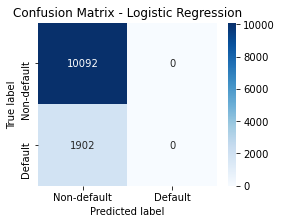

In [11]:

X = df_tratado.drop('default', axis=1)  
y = df_tratado['default']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)


# Setup the hyperparameter grid, (not scaled data)
param_grid = {'C': np.logspace(-5, 8, 15)}

# Instantiate a logistic regression classifier
logreg = LogisticRegression()

# Instantiate the RandomizedSearchCV object
logreg_cv = RandomizedSearchCV(logreg,param_grid , cv=5, random_state=0)

# Fit it to the data
logreg_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 


LR = LogisticRegression(C=0.00005, random_state=0)
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_pred,y_test))

## 5-fold cross-validation 
cv_scores =cross_val_score(LR, X, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,LR.predict(X_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Logistic Regression");

### Random Forest Classifier
* GINI = 2 * (AUC) - 1

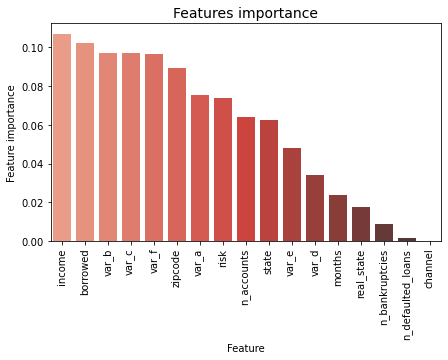

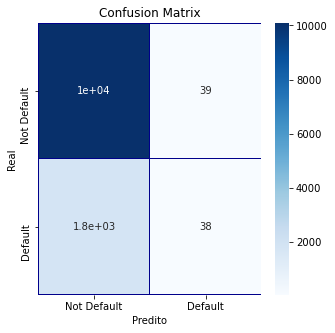

The area under ROCs curve: 0.5082625021935531


In [13]:
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

#RANDOMFORESTCLASSIFIER
RFC_METRIC = 'gini'  #metric used as 2*(AUC)-1
NUM_ESTIMATORS = 100 #number of estimators
NO_JOBS = 4 #number of parallel jobs

# Split data in train and validation set
train_df, val_df = train_test_split(df_tratado, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

# Initializing the Random Forest Classifier
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

# Features importance
target = 'default' # supervised
predictors = ['risk', 'var_a', 'var_b', 'var_c', 'var_d', 'var_e', 'var_f', 
              'borrowed', 'months', 'income', 'state', 'zipcode', 'channel',
              'real_state', 'n_bankruptcies', 'n_defaulted_loans', 'n_accounts']

clf.fit(train_df[predictors], train_df[target].values)

preds = clf.predict(val_df[predictors])

# Plot Feature Importance
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp, palette='Reds_d')
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

# Plot the Confusion Matrix
cm = pd.crosstab(val_df[target].values, preds, rownames=['Real'], colnames=['Predito'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix')
plt.show()

# The area under curve (receiver operator characteristic)
print('The area under ROCs curve: {}'.format(roc_auc_score(val_df[target].values, preds)))

### XGBoost
XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework

[16:01:36] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.63375	valid-auc:0.64361
[50]	train-auc:0.66559	valid-auc:0.67500
[100]	train-auc:0.68454	valid-auc:0.69367
[150]	train-auc:0.69010	valid-auc:0.69800
[200]	train-auc:0.69322	valid-auc:0.69965
[250]	train-auc:0.69569	valid-auc:0.70032
[300]	train-auc:0.69741	valid-auc:0.70037
[308]	train-auc:0.69769	valid-auc:0.70028


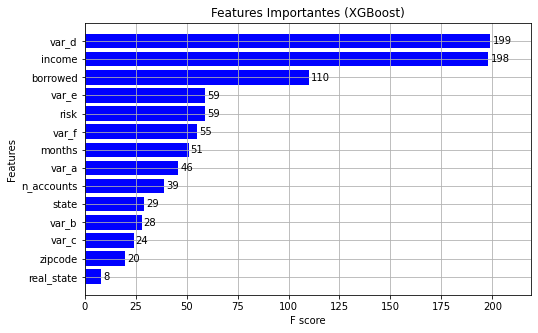

In [14]:
import xgboost as xgb

#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

# Split data in train and validation set
train_df, val_df = train_test_split(df_tratado, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(val_df[predictors], val_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

# Train the model
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

# Plot variable importance
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features Importantes (XGBoost)", ax=ax, color="blue") 
plt.show()

## Conclusão
1. Melhorar o processo de tratamento de dados;
2. Verificar melhores parâmetros para os modelos aplicados;
3. Retomar análise dos atributos e id's descartados, nova hipótese;
4. Observar a relação entre as variáveis como 'sex', 'default' e 'risk';
5. Observar a relação entre as variáveis 'default', 'no_job' e demais atributos que inclusive não foram considerados ainda.

## Apêndice

#### <b>Piechart: Default</b>

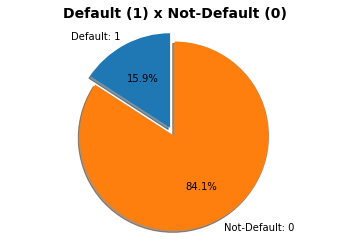

In [15]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Default: 1', 'Not-Default: 0'
sizes = [100*df_tratado['default'].sum()/df_tratado.shape[0], 
         100*(df_tratado.shape[0]-df_tratado['default'].sum())/df_tratado.shape[0]]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
plt.title('Default (1) x Not-Default (0)', font={'size': 14, 'weight': 'bold'})
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

#### <b>Boxplot: Sex x Risk</b>

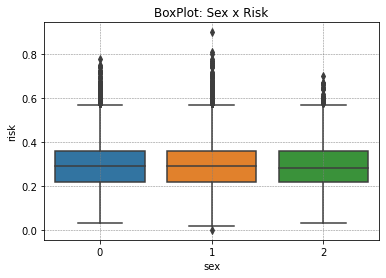

In [21]:
# Boxplot
sns.boxplot(x='sex', y='risk', data=df_tratado)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.title('BoxPlot: Sex x Risk')
plt.xlabel('sex')
plt.ylabel('risk')
plt.show()

#### Heatmap
* Verificar correlações entre as variáveis

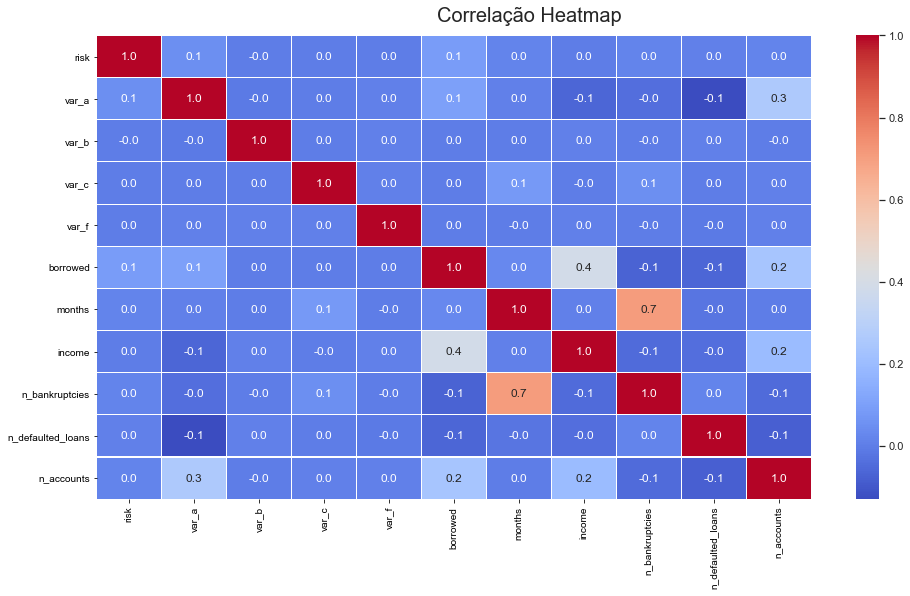

In [27]:
#Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(16, 8))
sns.set(font_scale=1.)
corr = df_tratado.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.1f', linewidths=.05)
f.subplots_adjust(top=0.93)
t = f.suptitle('Correlação Heatmap', fontsize=20)